use env: gio

In [1]:
from helpers import *

In [2]:
seed = 2
np.random.seed(seed)
# torch.manual_seed(seed);
# torch.set_num_threads(8)

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

data_path = "../../../data/SBI/POST/"

In [3]:
nn = 108
groups = ["RSC", "ACA", "Th", "CTRL"]

In [4]:
DS = G_Dataset("../../../data")
idx_regions_dict = DS.get_subnetwork_indices(kind="analysis", division=6)
idx_regions = list(idx_regions_dict.values())
idx_labels = list(idx_regions_dict.keys())
idx_labels

['DMN', 'Vis-Aud', 'LCN', 'BF', 'HPF', 'Th']

In [5]:
def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


# BOLD_file = (
#     "data/AllenConnectome/BOLD_data.pkl"
# )
# groups = ["RSC", "ACA", "Th", "CTRL"]

# BOLD = load_pickle(BOLD_file)

# n_subjects = {}
# for group in groups:
#     for subj in BOLD[group].keys():
#         n_subjects[group] = len(BOLD[group].keys()) // 2
# n_subjects

{'RSC': 14, 'ACA': 7, 'Th': 8, 'CTRL': 8}

In [6]:
def interpolate_vector(x, nt_new):
    nt = len(x)
    if nt == nt_new:
        return x
    else:
        return np.interp(np.linspace(0, nt, nt_new), np.arange(nt), x)
    

def interpolate_bold(bold, nt_new):
    '''  
    interpolate each row to have nn by nt_new matrix 
    
    bold : np.ndarray (nn x nt)
    '''
    nn, _ = bold.shape
    bold_new = np.zeros((nn, nt_new))
    for i in range(nn):
        bold_new[i] = interpolate_vector(bold[i], nt_new)
    
    # append nn x 50 zeros and the beginning and 50 x 1 zeros at the end
    bold_new = np.hstack([np.zeros((nn, 50)), bold_new, np.zeros((nn, 1))])

    return bold_new


def load_bold_emp(group, subject_id, prepost, BOLD, nt=900):

    bold = BOLD[group][f'{subject_id}_{prepost}'].T
    if group == "Th":
        bold = interpolate_bold(bold, nt)

    return bold


def preprocess(bold, nt=900, offset=50):
    bold = bold[:, offset:-1]
    bold = bold - np.mean(bold, axis=1, keepdims=True)
    return bold[:, :nt]


def get_features(bold, idx_dict):

    masks = {}
    for key, value in idx_dict.items():
        mask = make_mask(nn, value)
        masks[key] = mask
    masks["full"] = np.ones((nn, nn))
    bold = bold - np.mean(bold, axis=1)[:, None]
    fcds = get_fcd(bold, masks=masks, win_len=50)
    fcd = fcds["full"]
    fcd_var = np.var(fcd.flatten())
    fcd_sum = np.sum(fcd.flatten())
    fc = get_fc(bold, masks=masks)
    fc_flatten = fc["full"].flatten()
    fc_var = np.var(fc_flatten)
    fc_sum = np.sum(fc_flatten)
    # fcds = [np.var(fcds[key].flatten()) for key in idx_dict.keys()]
    fcs = [np.sum(fc[key].flatten()) for key in idx_dict.keys()]
    x_fc_sum_sub = np.array(fcs)
    # x_fcd_var_sub = np.array(fcds)
    return np.concatenate([[fcd_var], [fcd_sum], [fc_sum], [fc_var], x_fc_sum_sub]).squeeze()

In [7]:
# bold = load_bold_emp("Th", 1, "pre", BOLD)
# bold = preprocess(bold)
# bold.shape

In [8]:
with open(data_path+"data_opt_post.pickle", "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['bold', 'df_sim', 'df_emp', 'combinations'])

In [9]:
df_sim = data['df_sim']
df_emp = data['df_emp']

df_sim.head(2)

,group,kind,set,idx,fcd_var,fcd_sum,fc_sum,fc_var,fc_sum_dmn,fc_sum_vis,...,fc_sum_bf,fc_sum_hpf,fc_sum_th,G,eta_dmn,eta_vis,eta_lcn,eta_bf,eta_hpf,eta_th
74,RSC,sim,0,74,0.043136,3722.077318,464.183636,0.01470,55.136243,9.654092,...,16.099744,6.789801,22.860206,0.616031,-4.513906,-3.971884,-3.985008,-5.993835,-4.016037,-4.819780
75,RSC,sim,0,75,0.043068,3658.578931,459.500389,0.02114,15.754569,53.624921,...,21.983301,8.505120,27.586113,0.574702,-4.664470,-4.859856,-3.623419,-5.746527,-4.576885,-4.925047


In [10]:
Bold_sim = data["bold"]
Bold_sim.shape

(328, 108, 1000)

In [11]:
c = data['combinations']
group = c[0][0]
idx = c[0][1]
vec = []
print (group, idx)
for s in idx:
    # bold = load_bold_emp(group, s, "pre", BOLD)
    bold = preprocess(bold)
    features = get_features(bold, idx_regions_dict)
    vec.append(features)
vec = np.nanmean(vec, axis=0)
print(vec)

RSC [3 8 9]
[3.81947696e-02 6.66605469e+03 8.52500285e+02 1.45638061e-02
 6.43026543e+01 1.82517546e+01 4.75611809e+01 4.41264775e+01
 2.77190131e+01 5.89437628e+01]


In [12]:
bold_s = Bold_sim[0]
bold_s = preprocess(bold_s)
bold_s.shape

(108, 900)

In [13]:
selected_col = ['fcd_var', 'fcd_sum', 'fc_sum', 'fc_var', 'fcd_var_dmn', 
                'fc_sum_vis', 'fc_sum_lcn', 'fc_sum_bf', 'fc_sum_hpf', 'fc_sum_th']

In [14]:
def plot(df_s, df_e, f=""):

    selected_col = [
        "fcd_var",
        "fcd_sum",
        "fc_sum",
        "fc_var",
        "fc_sum_dmn",
        "fc_sum_vis",
        "fc_sum_lcn",
        "fc_sum_bf",
        "fc_sum_hpf",
        "fc_sum_th",
    ]
    fig, ax = plt.subplots(2, 5, figsize=(18, 6))
    fig.suptitle(f"{f}", fontsize=16)
    ax = ax.ravel()
    for i, col in enumerate(selected_col):
        x = df_s[col]
        y = df_e[col]

        corr = np.corrcoef(x, y)[0, 1]
        ax[i].scatter(x, y, c="k", s=10, alpha=0.6, label=f"corr: {corr:.2f}")        
        ax[i].set_title(col)
        ax[i].legend(loc='upper right')
        ax[i].set_xlabel("sim")
        ax[i].set_ylabel("emp")

    plt.tight_layout()
    # os.makedirs("data/figs", exist_ok=True)
    # plt.savefig(f"data/figs/all_samples_{f}.png", dpi=300)
    


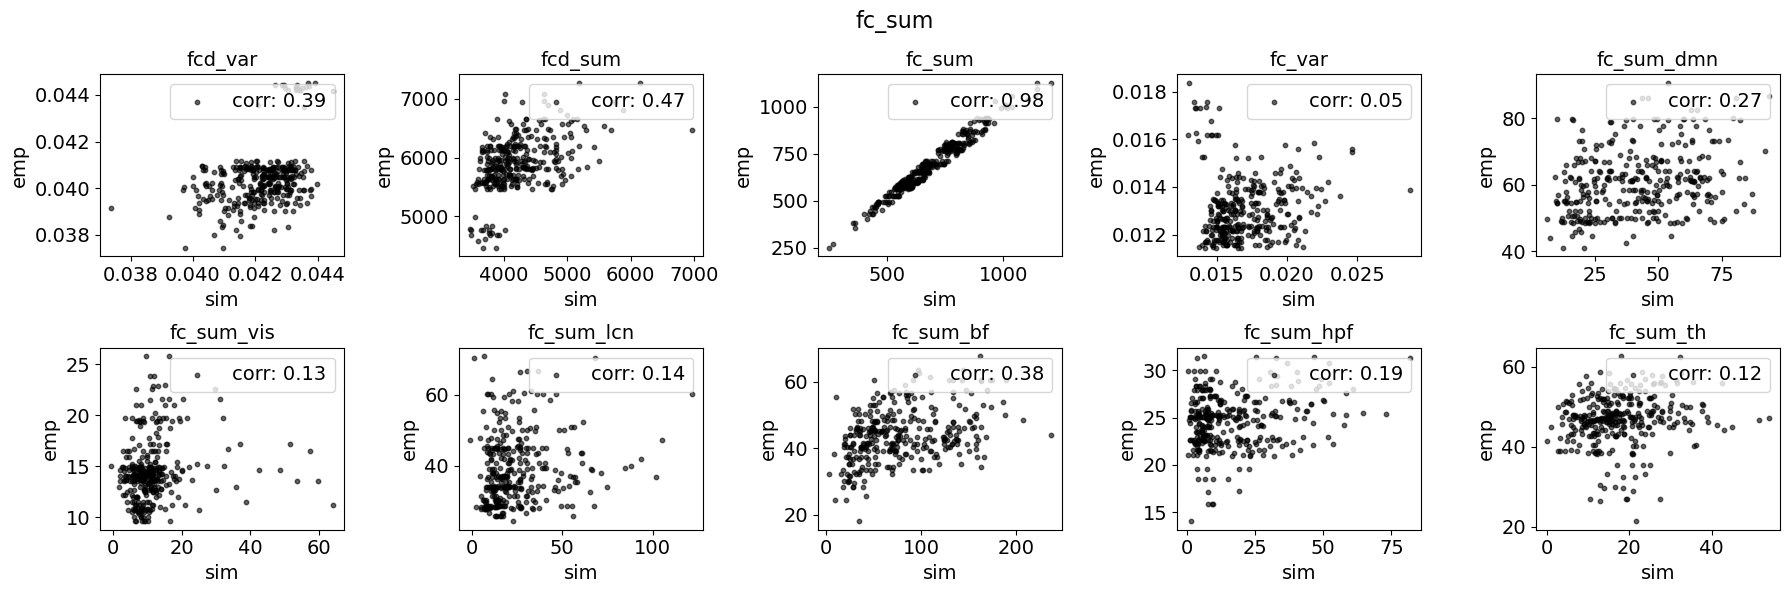

In [15]:
plot(df_sim, df_emp, f="fc_sum")